In [1]:
import numpy as np
from implementations_leo import *
from proj1_helpers import *
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
#Load the data both from train and test csv file
y, x, ids = load_csv_data("train.csv", sub_sample=False)
#_, x_submission, ids_submission = load_csv_data("test.csv", sub_sample=False)

In [5]:
#substitute non values with 0
#x[x==-999] = 0
print(x[:7,5:8])
x = getridof999(x)
print(x[:7,5:8])
#x_submission[x_submission == -999] = 0

[[  1.24711000e+02   2.66600000e+00   3.06400000e+00]
 [ -9.99000000e+02  -9.99000000e+02   3.47300000e+00]
 [ -9.99000000e+02  -9.99000000e+02   3.14800000e+00]
 [ -9.99000000e+02  -9.99000000e+02   3.31000000e+00]
 [ -9.99000000e+02  -9.99000000e+02   3.89100000e+00]
 [  2.84584000e+02  -5.40000000e-01   1.36200000e+00]
 [  1.58359000e+02   1.13000000e-01   2.94100000e+00]]
[[  1.24711000e+02   2.66600000e+00   3.06400000e+00]
 [  1.08470524e+02   7.25409999e-01   3.47300000e+00]
 [  1.06880886e+02   6.79437147e-01   3.14800000e+00]
 [  1.05642614e+02  -2.34952547e+00   3.31000000e+00]
 [  1.08355179e+02  -5.59115736e-01   3.89100000e+00]
 [  2.84584000e+02  -5.40000000e-01   1.36200000e+00]
 [  1.58359000e+02   1.13000000e-01   2.94100000e+00]]


In [4]:
def getridof999(x):
    for col in range(x.shape[1]):
        x1 = 1*x
        x1[x1==-999] = 0
        indices = [i for i,item in enumerate(x[:,col] == -999) if item]
        mean = np.mean(x1[:,col])
        norm = np.linalg.norm(x[:,col])/len(x1[:,col])
        for i in indices:
            x[i,col] = np.random.normal(mean, norm)
    return x

Correct answers:  74.2933333333 % for lambda = 0.000100
Correct answers:  74.4266666667 % for lambda = 0.000207
Correct answers:  74.5026666667 % for lambda = 0.000428
Correct answers:  74.5466666667 % for lambda = 0.000886
Correct answers:  74.492 % for lambda = 0.001833
Correct answers:  74.4506666667 % for lambda = 0.003793
Correct answers:  74.3706666667 % for lambda = 0.007848
Correct answers:  74.2066666667 % for lambda = 0.016238
Correct answers:  74.128 % for lambda = 0.033598
Correct answers:  73.9653333333 % for lambda = 0.069519
Correct answers:  74.0346666667 % for lambda = 0.143845
Correct answers:  74.1253333333 % for lambda = 0.297635
Correct answers:  74.2106666667 % for lambda = 0.615848
Correct answers:  74.324 % for lambda = 1.274275
Correct answers:  74.364 % for lambda = 2.636651
Correct answers:  74.3293333333 % for lambda = 5.455595
Correct answers:  74.2426666667 % for lambda = 11.288379
Correct answers:  74.108 % for lambda = 23.357215
Correct answers:  73.952 

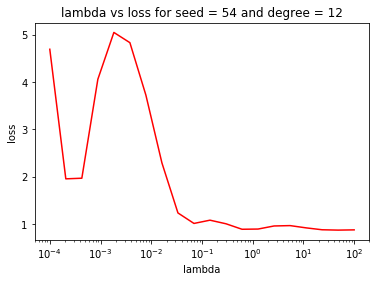

In [7]:
'''Define values to perform Ridge regression with simple splitting of the dataset'''

degree = 12
ratio = 0.7 #train/test examples
lambdas = np.logspace(-4,2,20)
seed = 54

ridge_with_simple_splitting(y,x, degree, ratio, lambdas, seed)

In [6]:
def ridge_with_simple_splitting(y,x, degree, ratio, lambdas, seed = 1):
    loss = []
    y_train, x_train, y_test, x_test = split_data(y, x, ratio, seed)

    phi_test = build_poly(x_test, degree, False)
    phi_train = build_poly(x_train, degree, False)

    for lambda_ in lambdas:

        w = ridge_regression(y_train, phi_train, lambda_)
        rmse_test = cost_function(y_test, phi_test, w)

        loss.append(rmse_test)

        print("Correct answers: ",predict(y_test,phi_test,w), '%', "for lambda = %f" %lambda_)
    semilog_loss_lambda_plot(loss, lambdas, seed, degree)

In [8]:
def cross_validation_ridge(y, x, k_fold, degree, lambdas, seed = 1):
    '''perform cross validation on ridge regression
    lambdas: array, better if log spaced
    print percentage of correct answers for each k, lambda
    plot in semilog scale rmse as function of lambda'''
    
    #create empty
    loss = np.zeros((len(lambdas))) 
    #add poly values to the features
    phi = build_poly(x, degree, False)
    #build indices for cross validation
    k_indices = build_k_indices(y, k_fold, seed)

    for k in range(k_fold):
        #split data according to kth fold
        y_train, phi_train, y_test, phi_test = split_data_cross(y, phi, k, k_indices, degree)

        loss_temp = [] #empty list to store losses for a given k
        
        for lambda_ in lambdas:
            w = ridge_regression(y_train, phi_train, lambda_)
            
            rmse_test = cost_function(y_test, phi_test, w)/k_fold #divide by k_fold in order to mean over them
            loss_temp.append(rmse_test)

            print("Correct answers: ",predict(y_test,phi_test,w), '%', "for k = %i, lambda = %f" %(k, lambda_))
        loss += loss_temp
    semilog_loss_lambda_plot(loss, lambdas, seed, degree)

Correct answers:  81.344 % for k = 0, lambda = 0.316228
Correct answers:  81.3488 % for k = 0, lambda = 0.379269
Correct answers:  81.3568 % for k = 0, lambda = 0.454878
Correct answers:  81.3616 % for k = 0, lambda = 0.545559
Correct answers:  81.3456 % for k = 0, lambda = 0.654319
Correct answers:  81.3312 % for k = 0, lambda = 0.784760
Correct answers:  81.3152 % for k = 0, lambda = 0.941205
Correct answers:  81.2896 % for k = 0, lambda = 1.128838
Correct answers:  81.3024 % for k = 0, lambda = 1.353876
Correct answers:  81.2592 % for k = 0, lambda = 1.623777
Correct answers:  81.104 % for k = 0, lambda = 1.947483
Correct answers:  54.3632 % for k = 0, lambda = 2.335721
Correct answers:  80.6368 % for k = 0, lambda = 2.801357
Correct answers:  80.9248 % for k = 0, lambda = 3.359818
Correct answers:  81.008 % for k = 0, lambda = 4.029611
Correct answers:  81.0416 % for k = 0, lambda = 4.832930
Correct answers:  81.056 % for k = 0, lambda = 5.796394
Correct answers:  81.0768 % for k =

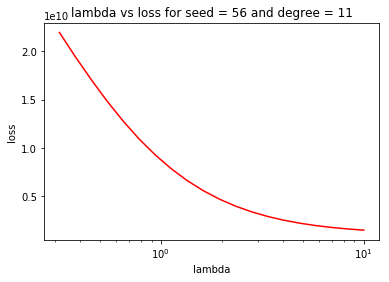

In [10]:
k_fold = 4
degree = 11
lambdas = np.logspace(-0.5,1,20)
seed = 56

cross_validation_ridge(y, x, k_fold, degree, lambdas, seed)

In [ ]:
def create_submission(x_submission, degree, ids_submission):
    phi_submission = build_poly(x_submission, degree, False) 

    y_predicted = np.sign(phi_submission.dot(w))
    create_csv_submission(ids_submission, y_predicted, "predictions_6.csv")